In [1]:
import torch
import os  # to make outdir
import os.path as op
from torch import nn, optim
import matplotlib.pyplot as plt
import mdtraj as md
import math
from utils import write_traj, save_traj
from cgae import *
import numpy as np
from cgae import *
from moviepy.editor import *  # to save images to gif

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# hyperparameters 
par = {}
par["n_atom"] = 32
par["N_cg"] = 3
par["lr"]  = 1e-4
par["batch_size"] = 20  
par["Tstart"] = 4.0      # starting temperature 
par["max_epoch"] = 800
par["n_mol"] = 1         # number of molecules, 
par["epoch_regularize"] = 400    # first epoch to include instataneous force regularization
par["rho"] = 0.005       # relative weight for force regularization
par["decay_ratio"] = 0.4 # the decay rate for the temperature annealing 
device = 'cpu'

In [3]:
# load data 
otp = md.load("data/otp.pdb")
otp_top = otp.top.to_dataframe()[0]
otp_element = otp_top['element'].values.tolist()
traj = np.load('data/otp_xyz.npy')
force = np.load('data/otp_force.npy')

In [4]:
# prepare data 
traj = traj[-3000:] * 10
force = force[-3000:] * 0.0239

N_cg = par["N_cg"]
n_atom = par["n_atom"]
n_mol = par["n_mol"]
batch_size = par["batch_size"]
n_batch = int(traj.shape[0] // batch_size)
n_sample = n_batch * batch_size
xyz = traj[:n_sample].reshape(-1, batch_size, n_mol, n_atom, 3)
force = force[:n_sample].reshape(-1, batch_size, n_atom, 3)
device = "cuda"

In [5]:
Encoder = encoder(in_dim=par["n_atom"], out_dim=par["N_cg"], hard=False, device=device).to(device)
Decoder = decoder(in_dim=par["N_cg"], out_dim=par["n_atom"]).to(device)

# Initialize Temperature Scheduler for Gumbel softmax 
t0 = par["Tstart"]
tmin = 0.2
temp = np.linspace(0, par["max_epoch"], par["max_epoch"] )

decay_epoch = int(par["max_epoch"] * par["decay_ratio"])
t_sched = t0 * np.exp(-temp/decay_epoch ) +  tmin
t_sched = torch.Tensor(t_sched).to(device)


# Initialize Optimizer 
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(list(Encoder.parameters()) + list(Decoder.parameters()), lr=par["lr"]) 

loss_log = []
loss_ae_log = []
loss_fm_log = []

In [6]:
DIRECTORY = "../pics/Wang/"
if not op.exists(DIRECTORY):
    os.makedirs(DIRECTORY)

epoch 0 reconstruction  6.209 instantaneous forces 816.339  tau  4.200
epoch 1 reconstruction  6.006 instantaneous forces 847.736  tau  4.188
epoch 2 reconstruction  5.820 instantaneous forces 842.096  tau  4.175
epoch 3 reconstruction  5.647 instantaneous forces 812.175  tau  4.163
epoch 4 reconstruction  5.488 instantaneous forces 877.981  tau  4.150
epoch 5 reconstruction  5.345 instantaneous forces 842.037  tau  4.138
epoch 6 reconstruction  5.210 instantaneous forces 828.700  tau  4.126
epoch 7 reconstruction  5.087 instantaneous forces 857.710  tau  4.113
epoch 8 reconstruction  4.974 instantaneous forces 828.152  tau  4.101
epoch 9 reconstruction  4.869 instantaneous forces 853.401  tau  4.089
epoch 10 reconstruction  4.773 instantaneous forces 878.501  tau  4.077
epoch 11 reconstruction  4.685 instantaneous forces 859.127  tau  4.065
epoch 12 reconstruction  4.603 instantaneous forces 831.918  tau  4.053
epoch 13 reconstruction  4.529 instantaneous forces 838.715  tau  4.041
ep

epoch 113 reconstruction  3.187 instantaneous forces 1339.880  tau  3.009
epoch 114 reconstruction  3.165 instantaneous forces 1524.184  tau  3.000
epoch 115 reconstruction  3.155 instantaneous forces 1393.119  tau  2.991
epoch 116 reconstruction  3.137 instantaneous forces 1412.695  tau  2.982
epoch 117 reconstruction  3.118 instantaneous forces 1411.294  tau  2.974
epoch 118 reconstruction  3.097 instantaneous forces 1422.929  tau  2.965
epoch 119 reconstruction  3.084 instantaneous forces 1391.656  tau  2.956
epoch 120 reconstruction  3.070 instantaneous forces 1450.401  tau  2.948
epoch 121 reconstruction  3.048 instantaneous forces 1516.587  tau  2.939
epoch 122 reconstruction  3.035 instantaneous forces 1524.828  tau  2.931
epoch 123 reconstruction  3.011 instantaneous forces 1518.050  tau  2.922
epoch 124 reconstruction  2.998 instantaneous forces 1422.247  tau  2.914
epoch 125 reconstruction  2.990 instantaneous forces 1459.209  tau  2.905
epoch 126 reconstruction  2.963 instan

epoch 224 reconstruction  1.396 instantaneous forces 1861.398  tau  2.185
epoch 225 reconstruction  1.387 instantaneous forces 1822.524  tau  2.178
epoch 226 reconstruction  1.364 instantaneous forces 1731.217  tau  2.172
epoch 227 reconstruction  1.354 instantaneous forces 1829.049  tau  2.166
epoch 228 reconstruction  1.339 instantaneous forces 1759.514  tau  2.160
epoch 229 reconstruction  1.325 instantaneous forces 1842.278  tau  2.154
epoch 230 reconstruction  1.306 instantaneous forces 1834.118  tau  2.148
epoch 231 reconstruction  1.300 instantaneous forces 1797.095  tau  2.142
epoch 232 reconstruction  1.282 instantaneous forces 1811.107  tau  2.136
epoch 233 reconstruction  1.275 instantaneous forces 1764.038  tau  2.129
epoch 234 reconstruction  1.255 instantaneous forces 1824.899  tau  2.123
epoch 235 reconstruction  1.235 instantaneous forces 1778.625  tau  2.117
epoch 236 reconstruction  1.215 instantaneous forces 1826.887  tau  2.111
epoch 237 reconstruction  1.210 instan

epoch 335 reconstruction  0.380 instantaneous forces 1921.297  tau  1.602
epoch 336 reconstruction  0.381 instantaneous forces 2030.539  tau  1.598
epoch 337 reconstruction  0.380 instantaneous forces 1915.149  tau  1.594
epoch 338 reconstruction  0.377 instantaneous forces 2056.435  tau  1.589
epoch 339 reconstruction  0.376 instantaneous forces 2027.756  tau  1.585
epoch 340 reconstruction  0.374 instantaneous forces 2046.402  tau  1.581
epoch 341 reconstruction  0.374 instantaneous forces 2040.894  tau  1.576
epoch 342 reconstruction  0.371 instantaneous forces 2056.441  tau  1.572
epoch 343 reconstruction  0.370 instantaneous forces 2046.378  tau  1.568
epoch 344 reconstruction  0.371 instantaneous forces 2060.522  tau  1.563
epoch 345 reconstruction  0.367 instantaneous forces 1960.479  tau  1.559
epoch 346 reconstruction  0.365 instantaneous forces 2022.179  tau  1.555
epoch 347 reconstruction  0.366 instantaneous forces 2054.511  tau  1.551
epoch 348 reconstruction  0.362 instan

epoch 446 reconstruction  0.346 instantaneous forces 2064.465  tau  1.191
epoch 447 reconstruction  0.344 instantaneous forces 1992.178  tau  1.188
epoch 448 reconstruction  0.344 instantaneous forces 2064.307  tau  1.185
epoch 449 reconstruction  0.345 instantaneous forces 2044.813  tau  1.182
epoch 450 reconstruction  0.343 instantaneous forces 2136.972  tau  1.179
epoch 451 reconstruction  0.344 instantaneous forces 2033.240  tau  1.175
epoch 452 reconstruction  0.344 instantaneous forces 2024.547  tau  1.172
epoch 453 reconstruction  0.345 instantaneous forces 1998.358  tau  1.169
epoch 454 reconstruction  0.342 instantaneous forces 1993.464  tau  1.166
epoch 455 reconstruction  0.344 instantaneous forces 2078.190  tau  1.163
epoch 456 reconstruction  0.344 instantaneous forces 2029.466  tau  1.160
epoch 457 reconstruction  0.342 instantaneous forces 2008.737  tau  1.157
epoch 458 reconstruction  0.344 instantaneous forces 2014.296  tau  1.154
epoch 459 reconstruction  0.343 instan

epoch 557 reconstruction  0.344 instantaneous forces 1986.219  tau  0.900
epoch 558 reconstruction  0.342 instantaneous forces 1978.003  tau  0.898
epoch 559 reconstruction  0.341 instantaneous forces 2006.195  tau  0.896
epoch 560 reconstruction  0.343 instantaneous forces 2005.766  tau  0.894
epoch 561 reconstruction  0.342 instantaneous forces 1972.319  tau  0.891
epoch 562 reconstruction  0.343 instantaneous forces 1949.304  tau  0.889
epoch 563 reconstruction  0.343 instantaneous forces 2021.880  tau  0.887
epoch 564 reconstruction  0.341 instantaneous forces 1962.595  tau  0.885
epoch 565 reconstruction  0.344 instantaneous forces 1986.248  tau  0.883
epoch 566 reconstruction  0.342 instantaneous forces 1963.630  tau  0.881
epoch 567 reconstruction  0.341 instantaneous forces 2070.166  tau  0.879
epoch 568 reconstruction  0.343 instantaneous forces 1958.568  tau  0.876
epoch 569 reconstruction  0.342 instantaneous forces 2097.441  tau  0.874
epoch 570 reconstruction  0.344 instan

epoch 668 reconstruction  0.341 instantaneous forces 2082.255  tau  0.695
epoch 669 reconstruction  0.342 instantaneous forces 2003.285  tau  0.693
epoch 670 reconstruction  0.339 instantaneous forces 1999.026  tau  0.692
epoch 671 reconstruction  0.344 instantaneous forces 2069.336  tau  0.690
epoch 672 reconstruction  0.340 instantaneous forces 1959.554  tau  0.689
epoch 673 reconstruction  0.344 instantaneous forces 2056.074  tau  0.687
epoch 674 reconstruction  0.340 instantaneous forces 1995.435  tau  0.685
epoch 675 reconstruction  0.342 instantaneous forces 2041.079  tau  0.684
epoch 676 reconstruction  0.343 instantaneous forces 2080.794  tau  0.682
epoch 677 reconstruction  0.343 instantaneous forces 1990.935  tau  0.681
epoch 678 reconstruction  0.342 instantaneous forces 2110.003  tau  0.679
epoch 679 reconstruction  0.344 instantaneous forces 2034.160  tau  0.678
epoch 680 reconstruction  0.342 instantaneous forces 2008.146  tau  0.676
epoch 681 reconstruction  0.343 instan

epoch 779 reconstruction  0.342 instantaneous forces 2007.187  tau  0.550
epoch 780 reconstruction  0.343 instantaneous forces 2181.115  tau  0.548
epoch 781 reconstruction  0.342 instantaneous forces 2080.529  tau  0.547
epoch 782 reconstruction  0.343 instantaneous forces 2125.525  tau  0.546
epoch 783 reconstruction  0.343 instantaneous forces 2090.316  tau  0.545
epoch 784 reconstruction  0.342 instantaneous forces 2034.672  tau  0.544
epoch 785 reconstruction  0.343 instantaneous forces 2052.959  tau  0.543
epoch 786 reconstruction  0.342 instantaneous forces 2077.950  tau  0.542
epoch 787 reconstruction  0.341 instantaneous forces 2034.292  tau  0.541
epoch 788 reconstruction  0.340 instantaneous forces 2079.723  tau  0.540
epoch 789 reconstruction  0.342 instantaneous forces 2025.034  tau  0.539
epoch 790 reconstruction  0.340 instantaneous forces 2101.983  tau  0.538
epoch 791 reconstruction  0.340 instantaneous forces 1979.784  tau  0.537
epoch 792 reconstruction  0.341 instan

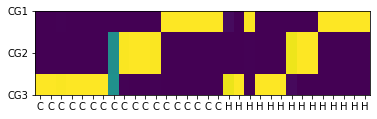

In [7]:
for epoch in range(par["max_epoch"]):  
        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
            
        for i, batch in enumerate(xyz):
            batch = torch.Tensor(batch.reshape(-1, n_atom, 3)).to(device) 
            cg_xyz = Encoder(batch, t_sched[epoch])
            CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch] * 0.7, device=device).t()

            decoded = Decoder(cg_xyz)
            loss_ae = criterion(decoded, batch)
            
            f0 = torch.Tensor(force[i].reshape(-1, n_atom, 3)).to(device)
            f = torch.matmul(CG, f0)
            mean_force = f.pow(2).sum(2).mean()

            loss_fm = mean_force
            
            if epoch >= par["epoch_regularize"]:
                loss = par["rho"] * loss_ae + par["rho"]  * mean_force
            else: 
                loss = par["rho"] * loss_ae

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
        
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)

        print("epoch %d reconstruction  %.3f instantaneous forces %.3f  tau  %.3f"  % (epoch, loss_ae_epoch, loss_fm_epoch, t_sched[epoch].item()))

        # Plot the mapping 
        CG = gumbel_softmax(Encoder.weight1.t(), t_sched[epoch], device=device).t()
        plt.imshow(CG.detach().cpu().numpy(), aspect=4)
        plt.xticks(np.arange(n_atom), otp_element)
        plt.yticks(np.arange(N_cg), ["CG" + str(i+1) for i in range(N_cg)])
        plt.savefig(op.join(DIRECTORY, str(epoch)+".png"))

In [8]:
# Save trajectory 
save_traj(Z=[1] * N_cg, traj=cg_xyz.detach().cpu().numpy(),name= 'CG.xyz')
save_traj(Z=otp_element, traj=decoded.detach().cpu().numpy(),name='decode.xyz')

In [9]:
files = [op.join(DIRECTORY, b) for b in [a for a in os.walk(DIRECTORY)][0][2]]
files = sorted(files, key=lambda x: int(op.split(x)[-1].replace(".png", "")))
clip = ImageSequenceClip(files, fps=24)
clip.write_gif("../pics/Wang.gif")

t:   1%|          | 8/801 [00:00<00:10, 79.15it/s, now=None]

MoviePy - Building file ../pics/Wang.gif with imageio.
